# Model for a membrane reactor

In this notebook we consider a reaction
$A \rightleftharpoons B + C$.
This reaction takes place in the annular region between two tubes, where the inner tube is a membrane that is only penetrable for component $C$. In the inner tube there is a sweep gas that sweeps component $C$ away. The goal is that by removing $C$ the reaction is shifted to the right.

In this first model, we have a very simple model of the membrane, namely as a boundary condition $c_C = 0$, i.e. component $C$ is immediately removed when it reaches the membrane. Another simplifying assumption in this first model is that the system is isothermal.

Complicating factors that are accounted for is the non-equimolar nature and 2D character of the problem.


### Used packages

The py_mrm package is a set of functions developed for Multiphase Reactor Modeling (MRM). It is used in the MRM course taught at the chemical engineering and chemistry department of Eindhoven University.

In [1]:
import math
import numpy as np
import scipy as sp
from scipy.sparse import linalg as sla
import matplotlib.pyplot as plt
import pymrm as mrm

Default parameters for plots

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14
plt.rcParams['font.serif'] = ['Times New Roman']  # Specify the desired font
plt.rcParams['axes.linewidth'] = 1.5  # Default linewidth for axes
plt.rcParams['lines.linewidth'] = 2.0  # Default linewidth for lines
plt.rcParams['axes.grid'] = True  # Show grid by default

### Governing equations

We solve a 2D axisymmetric convection-diffusion reaction equation of the form:

$$\frac{\partial}{\partial t} c_i+ \mathrm{div} ( \mathbf{v} \, c_i - D_i \, \mathrm{grad}(c_i) ) = r_i$$

The domain that will be considered is an annular region.
Inside the region, we assume a flow field of the form:

$$v_z =  v_\mathrm{prof}(r) \, \left ( -\frac{1}{\mu} \, \frac{\partial p}{\partial z}  \right ) $$

where for shape of the velocity profile we used the analytical solution for laminar flow in a annular region:

$$v_\mathrm{prof}(r) = \frac{1}{4}\left((r_\mathrm{max}^2-r^2) - (r_\mathrm{max}^2-r_\mathrm{min}^2) \, \frac{\ln(r_\mathrm{max}/r)}{\ln(r_\mathrm{max}/r_\mathrm{min})} \right) $$

For an annular region with a large enough aspect ratio the pressure variation in the radial direction will be very small. To enforce this, we specify the radial velocity as: $v_r = - C \, \,{\partial p}/{\partial r}$, with a constant $C$ that is sufficiently large. This is a numerical trick to make that the variation in pressure in the radial direction small. A typical value used is $C=(100/\mu) \, r_\mathrm{max}^2$.

### Numerical solution

Finding a numerically stable implementation for a 2D reactor model, where the velocities are not constant, but coupled with the species concentrations (and possibly also with the temperature) turns out to be very non-trivial.

In the current implementation, we propose a segregated solution method. Where, inside an inner iteration of the Newton-Raphson step we first solve for pressure and next for the species concentration.
We perform a spatial discretization of the gradient and divergence operators. Then for each grid point we define for each species $i$:

$g_{c,i} = \frac{c_i - c_\mathrm{{old},i}}{\Delta t} + \mathrm{div} \left( \mathbf{v} \, c_i - D_i \, \mathrm{grad}(c_i) \right ) - r_i = 0$

For all points the discretized equations are then $\mathbf{g}_c=0$.

This equation is solved in two Newton-Raphson steps.
First we consider the total mole-balances, by summing over the species index: $g_p = \sum_i g_{c,i}$.
We perform a Newton-Raphson step for the set of equations, $\mathbf{g}_p=0$, the pressures, $p$, where we substitute $c_i = x_i \, p/ RT$, with $x_i$ molar fractions. These mole fraction are kept fixed. When updating the pressure we also take into account the dependency of the velocities on the pressure gradients. This is a dominant contribution in the Jacobian for the pressure update.
After this update the molar concentrations are updated as $c_i = x_i \, p/ RT$.
Next, we perform a update of the concentrations by performing one NR step for $\mathbf{g}_c=0$. In the NR step the velocity field $\mathbf{v}$ is kept fixed.
After this update we compute the updated molar fractions, $x_i = c_i / c_\mathrm{tot}$, and then use the previously computed pressure to update the species concentrations as $c_i = x_i \, p/ RT$.

In [3]:
dim = 2
num_c = 3
num_r = 40
num_z = 50
L = 20
r_min = 1e-2
r_max = 1.5e-2
T_in = 293
Rg = 8.3114
p_out = 1e5
flux_in = 10.0*np.array([[[p_out/(Rg*T_in), 0, 0]]])
c_init = [[[0, p_out/(Rg*T_in), 0]]]
viscosity = 1e-3
k_f = 2.0e1
k_b = 4.0
D = np.array([[[1e-5, 2e-5, 2e-5]]])

dt = 1e-1
num_time_steps = 100
num_inner_iter = 50
tol = 1e-3
is_restart = False

v_prof = lambda r: 0.25*((r_max**2-r**2) - (r_max**2-r_min**2)*np.log(r_max/r)/np.log(r_max/r_min))
v_prof_avg = 0.125*(r_max**2 + r_min**2 - (r_max**2 - r_min**2)/np.log(r_max/r_min))

shape_c = (num_z, num_r, num_c)
shape_p = (num_z, num_r, 1)
#r_f = np.linspace(r_min, r_max, num_r+1)
r_f = mrm.non_uniform_grid(r_min, r_max, num_r+1, 0.05*(r_max-r_min), 1.2)
r_c = 0.5*(r_f[0:-1] + r_f[1:])
#z_f = np.linspace(0, L, num_z+1)
z_f = mrm.non_uniform_grid(0, L, num_z+1, 1.5*L/num_z, 1.4)
z_c = 0.5*(z_f[0:-1] + z_f[1:])
Vel_p = [None]*dim
vel_p_bc = [None]*dim
Div_p = [None]*dim

r_f_sq = r_f*r_f
dr_f_sq = r_f_sq[1:]-r_f_sq[0:-1]
weights_cup = v_prof(r_c) * dr_f_sq
weights_cup /= np.sum(weights_cup)
weights_cup = weights_cup.reshape((1,-1,1))

bc_p = {'a': [0,0], 'b': [0,1], 'd':[0,p_out]}
Grad, grad_bc = mrm.construct_grad(shape_p, z_f, z_c, bc=bc_p, axis=0)
k_field = np.ones((z_f.size,1)) * v_prof(r_c).reshape(1,-1)
K_matrix = mrm.construct_coefficient_matrix(k_field)
Vel_p[0] = (-1.0/viscosity)* K_matrix @ Grad
vel_p_bc[0] = (-1.0/viscosity)* K_matrix @ grad_bc
Div_p[0] = mrm.construct_div(shape_p, z_f, nu=0, axis=0)

bc_p = {'a': [1,1], 'b': [0,0], 'd':[0,0]}
Grad, grad_bc = mrm.construct_grad(shape_p, r_f, r_c, bc=bc_p, axis=1)
factor_dpdr = 1e-3*r_max*r_max/viscosity
Vel_p[1] = -factor_dpdr*Grad
vel_p_bc[1] = -factor_dpdr*grad_bc
Div_p[1] = mrm.construct_div(shape_p, r_f, nu=1, axis=1)

vel = [None]*dim
c_f = [None]*dim
flux_conv = [None]*dim

In [4]:
def reaction(c, k_f, k_b):
    r = np.zeros_like(c)
    r_f = k_f*c[:,:,0]
    r_b = k_b*c[:,:,1]*c[:,:,2]
    r[:,:,0] = -r_f + r_b
    r[:,:,1] =  r_f - r_b
    r[:,:,2] =  r_f - r_b
    return r

Flux_diff = [None]*dim
flux_diff_bc = [None]*dim
bc_c = [None]*dim
Div_c = [None]*dim
bc_c[0] = {'a': [0,1], 'b': [0,0], 'd':[0,0]}
Grad, grad_bc = mrm.construct_grad(shape_c, z_f, z_c, bc=bc_c[0], axis=0)
D_field = np.tile(D,(num_z+1, num_r))
D_matrix = mrm.construct_coefficient_matrix(D_field)
Flux_diff[0] = -D_matrix @ Grad
flux_diff_bc[0] = -D_matrix @ grad_bc
Div_c[0] = mrm.construct_div(shape_c, z_f, nu=0, axis=0)
Jac_c_const = Div_c[0] @ Flux_diff[0]
#flux_in_prof = sp.sparse.csc_array(((flux_in/v_prof_avg * v_prof(r_c).reshape(1,-1,1)).ravel(), range(num_r*num_c), [0,num_r*num_c]), shape=((num_z+1)*num_r*num_c, 1))
flux_in_prof = flux_in/v_prof_avg * v_prof(r_c).reshape((1,-1,1))
g_c_const = Div_c[0] @ flux_diff_bc[0]

bc_c[1] = {'a': [[[[1,1,0]]],1], 'b': [[[[0,0,1]]],0], 'd':[0,0]}
#bc_c[1] = {'a': [[[[1,1,1]]],1], 'b': [[[[0,0,0]]],0], 'd':[0,0]}
Grad, grad_bc = mrm.construct_grad(shape_c, r_f, r_c, bc=bc_c[1], axis=1)
D_field = np.tile(D,(num_z, num_r+1))
D_matrix = mrm.construct_coefficient_matrix(D_field)
Flux_diff[1] = -D_matrix @ Grad
flux_diff_bc[1] = -D_matrix @ grad_bc
Div_c[1] = mrm.construct_div(shape_c, r_f, nu=1, axis=1)
Jac_c_const += Div_c[1] @ Flux_diff[1]
g_c_const += Div_c[1] @ flux_diff_bc[1]

Jac_c_const += sp.sparse.eye(math.prod(shape_c), format='csc')/dt
indcs_dcdp = range(math.prod(shape_c))
indptr_dcdp = range(0,math.prod(shape_c)+num_c,num_c)
indcs_sum_c = np.arange(math.prod(shape_p)).repeat(num_c)
indptr_sum_c = range(math.prod(shape_c)+1)
Sum_c = sp.sparse.csc_array((np.ones(math.prod(shape_c)), indcs_sum_c, indptr_sum_c), shape=(math.prod(shape_p), math.prod(shape_c)))

if (not is_restart):
    c = np.tile(c_init,(num_z,num_r,1))
    c_tot = np.sum(c,dim,keepdims=True)
    p = c_tot*Rg*T_in
    vel[0] = (Vel_p[0]@p.reshape(-1,1) + vel_p_bc[0]).reshape((num_z+1, num_r,1))
    vel[0][0,:,:] = ((z_f[2]-z_f[0])*vel[0][1,:,:] - vel[0][2,:,:]*(z_f[1]-z_f[0]))/(z_f[2]-z_f[1])
    vel[1] = (Vel_p[1]@p.reshape(-1,1) + vel_p_bc[1]).reshape((num_z, num_r+1,1))
    c_f[0], dc_f = mrm.interp_cntr_to_stagg_tvd(c, z_f, z_c, bc_c[0], vel[0], mrm.minmod, axis=0)
    c_f[1], dc_f = mrm.interp_cntr_to_stagg_tvd(c, r_f, r_c, bc_c[1], vel[1], mrm.minmod, axis=1)
    Conv, conv_bc = mrm.construct_convflux_upwind(shape_c, z_f, z_c, bc_c[0], vel[0], axis=0)
    Jac_c_conv = Div_c[0] @ Conv
    flux_conv[0] = c_f[0]*vel[0]
    flux_conv[0][[0],:,:] = flux_in_prof
    g_c_conv = Div_c[0] @ flux_conv[0].reshape((-1,1))
    Conv, conv_bc = mrm.construct_convflux_upwind(shape_c, r_f, r_c, bc_c[1], vel[1], axis=1)
    Jac_c_conv += Div_c[1] @ Conv
    flux_conv[1] = c_f[1]*vel[1]
    g_c_conv += Div_c[1] @ flux_conv[1].reshape((-1,1))

for i in range(num_time_steps):
    c_old = c.copy()
    converged = False
    j = 0
    while (not converged) and (j<num_inner_iter):
        c_tot = np.sum(c,dim,keepdims=True)
        molfrac = c / c_tot
        c = molfrac * p/(Rg*T_in)
        g_react, Jac_react = mrm.numjac_local(lambda c: reaction(c, k_f, k_b), c, axis = dim)
        g_c_no_conv = Jac_c_const @ c.reshape((-1,1)) + g_c_const - c_old.reshape((-1,1))/dt - g_react.reshape((-1,1))
        Jac_c_no_conv = Jac_c_const - Jac_react
        Jac_c = Jac_c_no_conv + Jac_c_conv
        g_c = g_c_no_conv + g_c_conv
        dcdp_field = molfrac/(Rg*T_in)
        DcDp = sp.sparse.csc_array((dcdp_field.ravel(), indcs_dcdp, indptr_dcdp), shape=(math.prod(shape_c), math.prod(shape_p)))
        Jac_p = Sum_c @ Jac_c @ DcDp
        C_f = mrm.construct_coefficient_matrix(np.sum(c_f[0],dim))
        Jac_p = Jac_p + Div_p[0] @ C_f @ Vel_p[0]
        C_f = mrm.construct_coefficient_matrix(np.sum(c_f[1],dim))
        Jac_p += Div_p[1] @ C_f @ Vel_p[1]
        g_p = np.sum(g_c.reshape(shape_c),dim).reshape(-1,1)
        Jac_p_lu = sla.splu(Jac_p)
        p -= (Jac_p_lu.solve(g_p)).reshape(shape_p)
        c_new = molfrac * (p/(Rg*T_in))
      
        vel[0] = (Vel_p[0]@p.reshape(-1,1) + vel_p_bc[0]).reshape((num_z+1, num_r,1))
        vel[0][0,:,:] = ((z_f[2]-z_f[0])*vel[0][1,:,:] - vel[0][2,:,:]*(z_f[1]-z_f[0]))/(z_f[2]-z_f[1])
        vel[1] = (Vel_p[1]@p.reshape(-1,1) + vel_p_bc[1]).reshape((num_z, num_r+1,1))
        c_f[0], dc_f = mrm.interp_cntr_to_stagg_tvd(c_new, z_f, z_c, bc_c[0], vel[0], mrm.minmod, axis=0)
        c_f[1], dc_f = mrm.interp_cntr_to_stagg_tvd(c_new, r_f, r_c, bc_c[1], vel[1], mrm.minmod, axis=1)

        Conv, conv_bc = mrm.construct_convflux_upwind(shape_c, z_f, z_c, bc_c[0], vel[0], axis=0)
        Jac_c_conv = Div_c[0] @ Conv
        flux_conv[0] = c_f[0]*vel[0]
        flux_conv[0][[0],:,:] = flux_in_prof
        g_c_conv = Div_c[0] @ flux_conv[0].reshape((-1,1))
        Conv, conv_bc = mrm.construct_convflux_upwind(shape_c, r_f, r_c, bc_c[1], vel[1], axis=1)
        Jac_c_conv += Div_c[1] @ Conv
        flux_conv[1] = c_f[1]*vel[1]
        g_c_conv += Div_c[1] @ flux_conv[1].reshape((-1,1))

        #g_c_no_conv += Jac_c_no_conv @ dc.reshape((-1,1))

        Jac_c = Jac_c_no_conv + Jac_c_conv
        g_c = g_c_no_conv + g_c_conv
        Jac_lu = sla.splu(Jac_c)
        dc = -(Jac_lu.solve(g_c)).reshape(shape_c)
        c += dc
        j += 1
        converged = (np.linalg.norm(dc.ravel(), ord=np.inf) < tol)
    print(f'\r time step: {i}, number of iterations: {j}',end='')

 time step: 99, number of iterations: 1

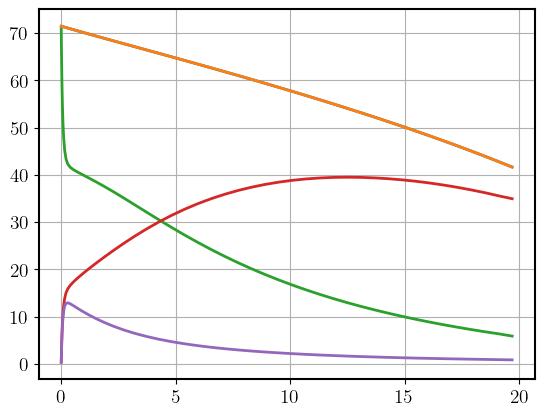

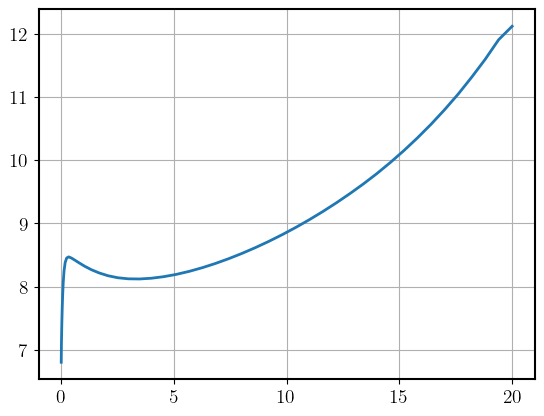

In [5]:
c_av = np.sum(weights_cup*c,axis=1)
p_av = np.sum(weights_cup*p,axis=1)
plt.plot(z_c,p_av/(Rg*T_in))
plt.plot(z_c,np.sum(c_av,axis=1))
plt.plot(z_c,c_av[:,0])
plt.plot(z_c,c_av[:,1])
plt.plot(z_c,c_av[:,2])
plt.show()

v_av = np.sum(weights_cup*vel[0],axis=1)
plt.plot(z_f,v_av[:,0])
plt.show()


C:\Users\eajfpeters\AppData\Local\Temp\ipykernel_36708\3497023323.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


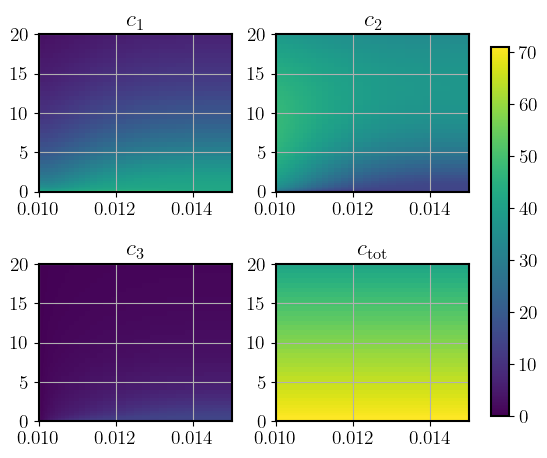

In [6]:
c_max = np.max(c)
fig, ax = plt.subplots(2,2)
ax[0,0].pcolormesh(r_f, z_f, c[:,:,0], shading='flat', cmap='viridis', vmin=0, vmax = c_max)
ax[0, 0].set_title(r'$c_1$')
ax[0,1].pcolormesh(r_f, z_f, c[:,:,1], shading='flat', cmap='viridis', vmin=0, vmax = c_max)
ax[0,1].set_title(r'$c_2$')
ax[1,0].pcolormesh(r_f, z_f, c[:,:,2], shading='flat', cmap='viridis', vmin=0, vmax = c_max)
ax[1,0].set_title(r'$c_3$')
pcm = ax[1,1].pcolormesh(r_f, z_f, np.sum(c,dim), shading='flat', cmap='viridis', vmin=0, vmax = c_max)
ax[1, 1].set_title(r'$c_\mathrm{tot}$')
cbar = fig.colorbar(pcm, ax=ax, orientation='vertical')
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()